# Problem Statement

A hedge fund uses 6 financial factors to predict the alpha signal in a stock. This alpha signal is used to make purchase decisions about the stock. The hedge fund now collected and tagged microblogging data for sentiment from the Social Media platform called ‘StockTwits’. 
 
StockTwits is used by people who regularly trade stocks. People on this platform tweet about stocks using the special character ‘$’ to indicate the name of the stock. These microblogs similar to tweets might contain important information about the alpha signal in a stock. 
 
Your goal is to build a sentiment analysis model using the tagged data. This sentiment analysis model should then be used to generate a new stock factor which together with the other stock factors should be used to predict the Alpha Signal. 
 
The hedge fund has anonymyzed the data, which contains 7 stock factors and an alpha signal. This alpha signal is generated using a near perfect algorithmic trading strategy. Unfortunately, the number of stock factors, collected to run that strategy, are extremely high and have to be collected from a large number of data vendors at a high price. 
 
Replicating the alpha signal generated from that strategy using just the 7 Stock Factors and the factor generated from sentiment analysis of the stocktwits would make the company incur significantly less costs to perform their trades.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
import missingno as msno
import re, string, unicodedata
import nltk
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import string
import time
from time import sleep
from tqdm import tqdm_notebook as tq
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle


# Reading the Dataset

## Train Factors

In [2]:
train_data = pd.read_csv('train_factors-1573207730757.csv')

In [3]:
train_data.tail()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
27001,27002,05/10/18,$RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3
27002,27003,30/07/18,$PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3
27003,27004,16/10/18,$JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2
27004,27005,27/07/18,$NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3
27005,27006,14/10/18,$WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2


## Sentiment Train

In [4]:
json_file = 'train_data-1573118738755.json'

with open(json_file) as data:
    data_json = json.load(data)

**We can see that 'records' is the parent node.**

In [5]:
json_data = json_normalize(data_json['records']) 
json_data.head(3) 

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00


In [6]:
json_data.shape

(1039131, 4)

In [7]:
json_data['stocktwit_tweet'][1]

'@inforlong @MariaGascon Despite\nChina trade war $CAT held very well 👍'

## Test Data

In [90]:
test_data = pd.read_csv('test_factors.csv')

In [91]:
test_data.tail(2)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
11573,281580,22/07/18,$RF,-0.027608,0.811717,-0.148925,-0.700263,0.263678,-0.180345,0.435261
11574,281581,26/07/18,$bbby,0.591726,0.435771,-0.009138,-0.912432,-0.410299,0.072242,1.063584


In [92]:
json_file_test = 'test_data.json'

with open(json_file_test) as data:
    data_json_test = json.load(data)

In [93]:
json_data_test = json_normalize(data_json_test['records']) 
json_data_test.head(3) 

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00


# Exploratory Data Analysis

## For Train Factors

### Summary Statistics

In [8]:
train_data.describe(include = 'all')

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
count,27006.000000,27006,27006,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000
unique,NaN,123,1304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,26/07/18,$BAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,344,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,13503.500000,NaN,NaN,0.005429,-0.001005,-0.024421,-0.042420,0.041465,0.002597,0.036744,2.379582
std,7796.105021,NaN,NaN,0.941853,0.996130,0.539555,1.111309,0.976028,0.998839,1.204473,1.008681
min,1.000000,NaN,NaN,-4.114670,-4.578587,-2.609150,-6.329798,-5.480268,-4.338751,-5.347869,1.000000
25%,6752.250000,NaN,NaN,-0.596792,-0.666310,-0.300187,-0.767247,-0.518641,-0.668027,-0.688198,2.000000
50%,13503.500000,NaN,NaN,0.012104,-0.013257,-0.040786,-0.058629,0.072127,0.007417,0.081374,2.000000
75%,20254.750000,NaN,NaN,0.611574,0.669094,0.241424,0.677433,0.616538,0.674592,0.807556,3.000000


**There are 344 unique date entries and 1304 unique companies out of 27006.**

### Missing Value

Total Missing Values in Columns: 

 Id        0
date      0
ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
alpha     0
dtype: int64


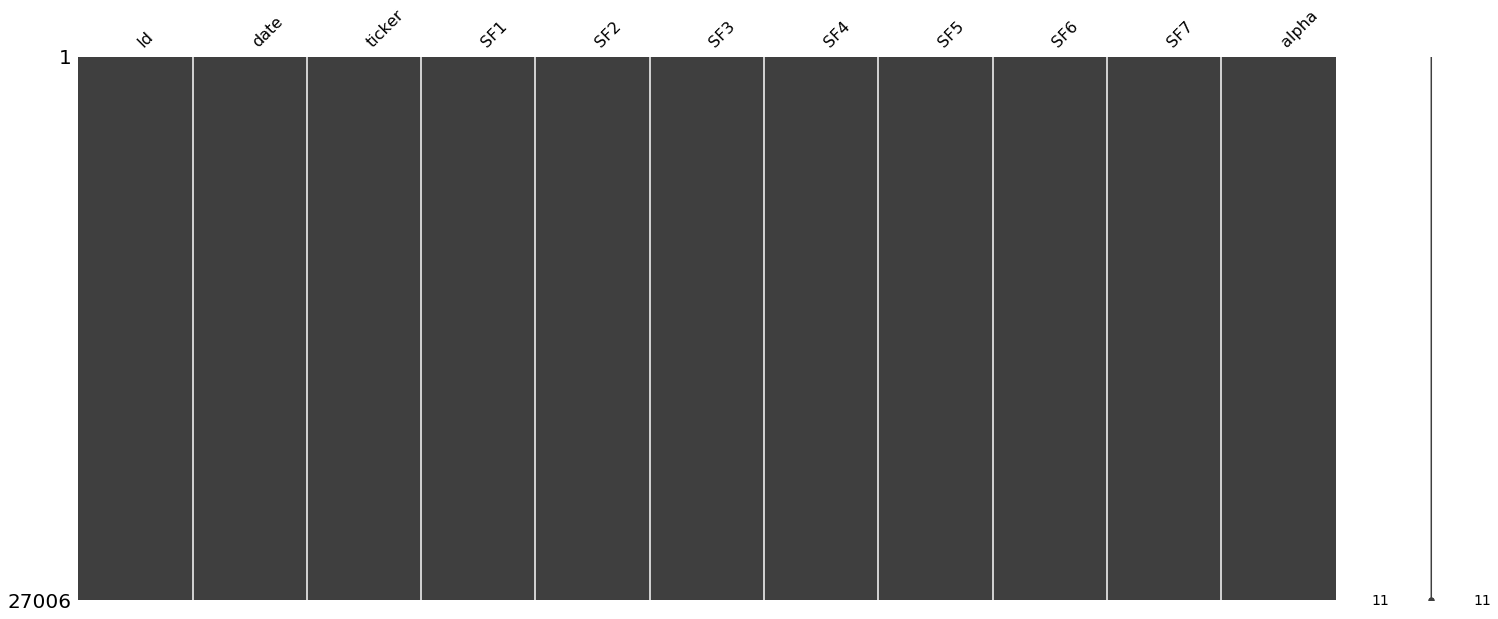

In [9]:
msno.matrix(train_data)
print('Total Missing Values in Columns: \n\n', train_data.isnull().sum())

**There are no missing values.**

### Data Types

In [10]:
train_data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
dtype: object

In [11]:
for i in train_data.columns:
    if train_data[i].dtypes == 'object':
        train_data[i] = train_data[i].astype('category')

## For Train Sentiment

### Summary Statistics

In [12]:
json_data.describe(include = 'all')

,sentiment_score,stocktwit_tweet,ticker,timestamp
count,1.039131e+06,1039131,1039131,1039131
unique,NaN,959608,2181,905458
top,NaN,$AMD,$AMD,2018-08-13 14:00:03+00:00
freq,NaN,2474,163675,65
mean,2.203079e+00,NaN,NaN,NaN
std,1.105371e+00,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN
25%,2.000000e+00,NaN,NaN,NaN
50%,2.000000e+00,NaN,NaN,NaN
75%,3.000000e+00,NaN,NaN,NaN


### Missing Value

Total Missing Values in Columns: 

 sentiment_score    0
stocktwit_tweet    0
ticker             0
timestamp          0
dtype: int64


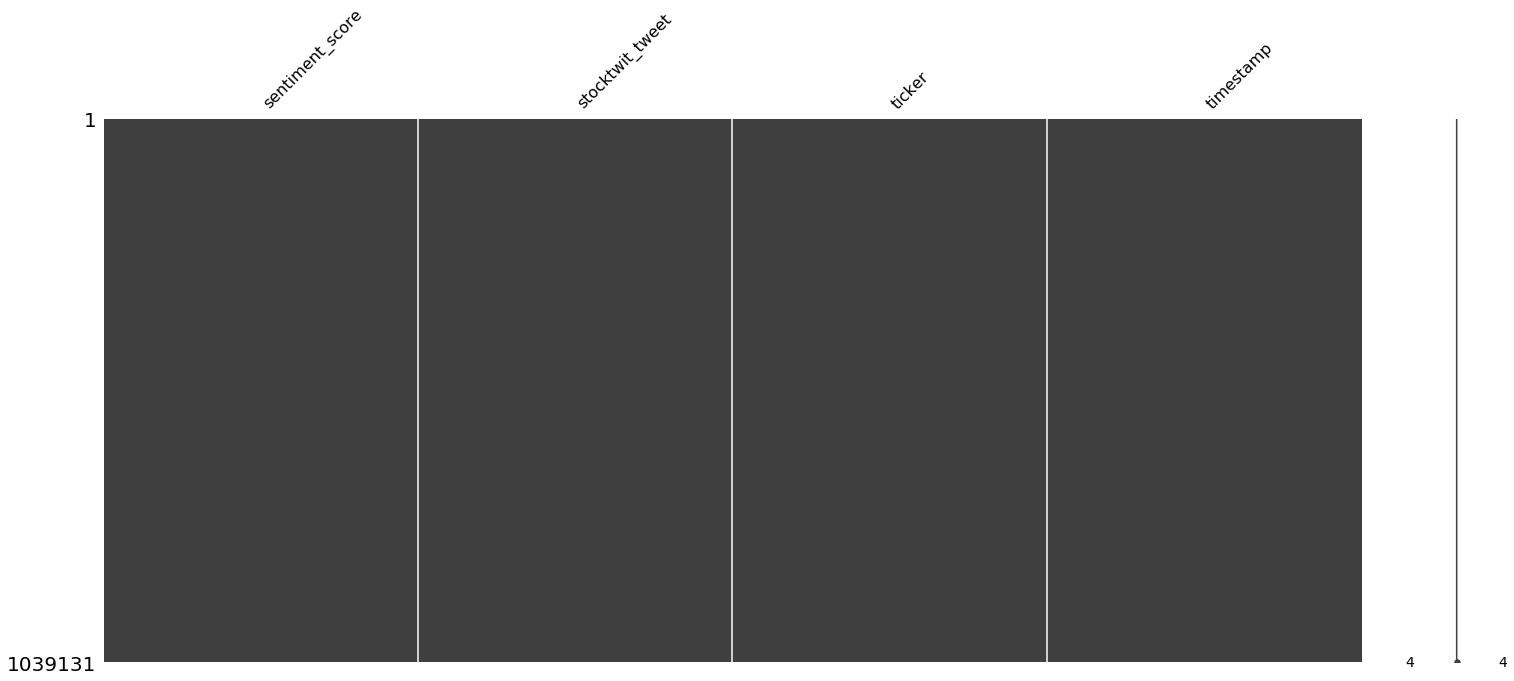

In [13]:
msno.matrix(json_data)
print('Total Missing Values in Columns: \n\n', json_data.isnull().sum())

**There are no missing values.**

### Data Types

In [14]:
json_data.dtypes

sentiment_score     int64
stocktwit_tweet    object
ticker             object
timestamp          object
dtype: object

In [15]:
for i in json_data.columns:
    if json_data[i].dtype == 'object':
        json_data[i] = json_data[i].astype('category')

## Test Data

### Summary Statistics

In [94]:
test_data.describe(include = 'all')

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
count,11575.000000,11575,11575,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000,11575.000000
unique,NaN,123,1012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,25/07/18,$AMZN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,152,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,275794.000000,NaN,NaN,0.001546,0.003995,-0.029754,-0.047606,0.053956,-0.000428,0.037914
std,3341.559017,NaN,NaN,0.924519,0.997903,0.537651,1.097842,0.965109,1.003503,1.192223
min,270007.000000,NaN,NaN,-4.130410,-4.034445,-4.259227,-4.704038,-4.545787,-4.317883,-5.031257
25%,272900.500000,NaN,NaN,-0.580470,-0.673206,-0.308838,-0.754051,-0.502280,-0.682896,-0.684029
50%,275794.000000,NaN,NaN,0.011865,-0.001464,-0.044590,-0.055108,0.084598,0.008303,0.081955
75%,278687.500000,NaN,NaN,0.600965,0.685805,0.228484,0.649046,0.620426,0.680800,0.807105


In [95]:
json_data_test.describe(include = 'all')

,stocktwit_tweet,ticker,timestamp
count,265022,265022,265022
unique,252890,1444,254753
top,$AMD,$AMD,2018-10-29 14:00:03+00:00
freq,622,42140,18


### Data Types

In [96]:
test_data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
dtype: object

In [97]:
for i in test_data.columns:
    if test_data[i].dtypes == 'object':
        test_data[i] = test_data[i].astype('category')

In [98]:
json_data_test.dtypes

stocktwit_tweet    object
ticker             object
timestamp          object
dtype: object

In [99]:
for i in json_data.columns:
    if json_data[i].dtype == 'object':
        json_data[i] = json_data[i].astype('category')

# Data Preprocessing

## Train Factors

In [16]:
train_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [17]:
print('Unique Days for which data is collected -', train_data['date'].str.split('/', expand = True)[0].unique(),
      '\nUnique Months for which data is collected -', train_data['date'].str.split('/', expand = True)[1].unique(),
      '\nUnique Years for which data is collected -', train_data['date'].str.split('/', expand = True)[2].unique())

Unique Days for which data is collected - ['21' '11' '10' '12' '16' '25' '27' '24' '15' '31' '28' '09' '04' '26'
 '23' '06' '17' '18' '19' '05' '08' '01' '03' '02' '07' '22' '30' '29'
 '20' '14' '13'] 
Unique Months for which data is collected - ['08' '10' '07' '09'] 
Unique Years for which data is collected - ['18']


In [18]:
train_data['Day'] = train_data['date'].str.split('/', expand = True)[0]
train_data['Month'] = train_data['date'].str.split('/', expand = True)[1]

In [19]:
# Stripping '$' from ticker
train_data['ticker'] = train_data['ticker'].str.split('$', expand = True)[1]

In [20]:
train_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
0,1,21/08/18,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,08
1,2,11/10/18,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,10
2,3,21/08/18,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,21,08
3,4,10/07/18,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,10,07
4,5,12/09/18,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,12,09


In [21]:
train_data.dtypes

Id           int64
date      category
ticker      object
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
alpha        int64
Day         object
Month       object
dtype: object

In [22]:
train_data['ticker'] = train_data['ticker'].astype('category')
train_data['Day'] = train_data['Day'].astype('int')
train_data['Month'] = train_data['Month'].astype('int')

## Test Factors

In [100]:
test_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,24/10/18,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,27/07/18,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [101]:
test_data['Day'] = test_data['date'].str.split('/', expand = True)[0]
test_data['Month'] = test_data['date'].str.split('/', expand = True)[1]

In [102]:
# Stripping '$' from ticker
test_data['ticker'] = test_data['ticker'].str.split('$', expand = True)[1]

In [103]:
test_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month
0,270007,21/07/18,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,21,07
1,270008,05/10/18,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,05,10
2,270009,01/10/18,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,01,10
3,270010,24/10/18,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,24,10
4,270011,27/07/18,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,27,07


In [104]:
test_data.dtypes

Id           int64
date      category
ticker      object
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
Day         object
Month       object
dtype: object

In [105]:
train_data['ticker'] = train_data['ticker'].astype('category')
train_data['Day'] = train_data['Day'].astype('int')
train_data['Month'] = train_data['Month'].astype('int')

## Sentiment Train

In [23]:
json_data.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


**From timestamp we extract the date of the tweet.**

In [24]:
json_data['date'] = json_data['timestamp'].str.split(' ', expand = True)[0]

In [25]:
json_data.tail()

,sentiment_score,stocktwit_tweet,ticker,timestamp,date
1039126,2,$CLF https://twitter.com/hrdrckminer/status/10...,$CLF,2018-08-13 22:15:04+00:00,2018-08-13
1039127,3,$AMD 🔥🔥🔥,$AMD,2018-09-04 15:25:59+00:00,2018-09-04
1039128,0,$FB damn should of shorted 196 after hours to ...,$FB,2018-07-25 21:29:03+00:00,2018-07-25
1039129,0,$AMD back to the 31&#39;s,$AMD,2018-09-28 16:19:55+00:00,2018-09-28
1039130,2,$AMZN Lagging other tech today.,$AMZN,2018-07-05 17:14:00+00:00,2018-07-05


**Extracting only the day and month of the tweet.**

In [26]:
json_data['month_of_tweet'] = json_data['date'].str.split('-', expand = True)[1]
json_data['day_of_tweet'] = json_data['date'].str.split('-', expand = True)[2]

In [27]:
json_data.tail()

,sentiment_score,stocktwit_tweet,ticker,timestamp,date,month_of_tweet,day_of_tweet
1039126,2,$CLF https://twitter.com/hrdrckminer/status/10...,$CLF,2018-08-13 22:15:04+00:00,2018-08-13,08,13
1039127,3,$AMD 🔥🔥🔥,$AMD,2018-09-04 15:25:59+00:00,2018-09-04,09,04
1039128,0,$FB damn should of shorted 196 after hours to ...,$FB,2018-07-25 21:29:03+00:00,2018-07-25,07,25
1039129,0,$AMD back to the 31&#39;s,$AMD,2018-09-28 16:19:55+00:00,2018-09-28,09,28
1039130,2,$AMZN Lagging other tech today.,$AMZN,2018-07-05 17:14:00+00:00,2018-07-05,07,05


In [28]:
sent_data = json_data.drop(columns=['timestamp', 'date'])

In [29]:
# Stripping '$' from ticker
sent_data['ticker'] = sent_data['ticker'].str.split('$', expand = True)[1]

In [30]:
sent_data.tail(3)

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet
1039128,0,$FB damn should of shorted 196 after hours to ...,FB,07,25
1039129,0,$AMD back to the 31&#39;s,AMD,09,28
1039130,2,$AMZN Lagging other tech today.,AMZN,07,05


In [31]:
sent_data.dtypes

sentiment_score       int64
stocktwit_tweet    category
ticker               object
month_of_tweet       object
day_of_tweet         object
dtype: object

In [32]:
sent_data['day_of_tweet'] = sent_data['day_of_tweet'].astype('int')
sent_data['month_of_tweet'] = sent_data['month_of_tweet'].astype('int')

## Test Sentiment

In [106]:
json_data_test['date'] = json_data_test['timestamp'].str.split(' ', expand = True)[0]


json_data_test['month_of_tweet'] = json_data_test['date'].str.split('-', expand = True)[1]
json_data_test['day_of_tweet'] = json_data_test['date'].str.split('-', expand = True)[2]


sent_data_test = json_data_test.drop(columns=['timestamp', 'date'])

# Stripping '$' from ticker
sent_data_test['ticker'] = sent_data_test['ticker'].str.split('$', expand = True)[1]

print(sent_data_test.tail(3))

print(sent_data_test.dtypes)

sent_data_test['day_of_tweet'] = sent_data_test['day_of_tweet'].astype('int')
sent_data_test['month_of_tweet'] = sent_data_test['month_of_tweet'].astype('int')

                                          stocktwit_tweet ticker  \
265019  $AMD Could be at 18 or high 17s.  If not, will...    AMD   
265020  $TSN files form 10-Q https://fintel.io/filings...    TSN   
265021  $AAPL looks like it is solidly supporting its ...   AAPL   

       month_of_tweet day_of_tweet  
265019             07           25  
265020             08           06  
265021             09           27  
stocktwit_tweet    object
ticker             object
month_of_tweet     object
day_of_tweet       object
dtype: object


## Text Preprocessing - Sentiment 

In [33]:
sent_data.head()

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet
0,3,$AMD going up but hesitating however chart is ...,AMD,9,19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,9
2,2,$AVGO WTF?,AVGO,7,12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,7,19
4,3,$FB if it bounces tommorrow do the right thing...,FB,8,23


**To predict the sentiment of the tweet, we need to clean the tweet data.**

### Text Data Cleaning - Train

Ticker tag - $

User tag - @

In [34]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_punctuation(text):
    for c in string.punctuation:
        text = text.replace(c,"")
    return text

def remove_digits(text):
    return re.sub('[\d%/$]', '', text)

def to_lower_case(text):
    text = text.lower()
    return text


In [35]:
pattern_user = r'@[A-Za-z0-9]+'
pattern_tick = r'\$\w+'
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
url_pattern = r'http\S+'

In [36]:
def text_cleaner(text):
    text1 = re.sub(pattern_user, "", text) # remove user tags
    text2 = re.sub(pattern_tick, "", text1) # remove ticker tags
    text3 = re.sub(emoji_pattern, "", text2) # remove emojis
    text4 = re.sub(url_pattern, '', text3) # remove URLs
    text5 = re.sub(r':', '', text4) # remove colon
    text6 = remove_accented_chars(text5) # remove accented chars
    text7 = remove_punctuation(text6) # remove punctuation
    text8 = to_lower_case(text7) # convert to lower case
    text9 = remove_digits(text8) # remove numbers
    text10 = text9.replace('\n', ' ') # replace newline character with space
    return text10

In [37]:
clean_text = []

for i in tq(sent_data['stocktwit_tweet']):
    sleep(0.01)
    
    clean_text.append(text_cleaner(i))

In [38]:
len(clean_text)

1039131

In [39]:
clean_text[250]

'  jpmorgan laying off around  employees in assetmanagement business   '

In [40]:
sent_data['clean_text'] = clean_text

In [41]:
num = np.random.randint(sent_data.shape[0])
sent_data[num:(num+5)]

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet,clean_text
880335,2,$AMAT That wasn&#39;t a chunk of the sky that ...,AMAT,7,3,that wasnt a chunk of the sky that just hit y...
880336,1,$AMD the reversal will certainly be dramatic,AMD,8,24,the reversal will certainly be dramatic
880337,2,$DIS is one of our 20-day forward top picks. W...,DIS,9,18,is one of our day forward top picks we estima...
880338,2,$VTR Market Positioning is Slightly Overweight...,VTR,7,30,market positioning is slightly overweight cro...
880339,1,"$JCP Holiday inventory is bought and paid for,...",JCP,9,28,holiday inventory is bought and paid for sill...


### Text Data Cleaning - Test

In [107]:
clean_text_test = []

for i in tq(sent_data_test['stocktwit_tweet']):
    sleep(0.01)
    
    clean_text_test.append(text_cleaner(i))

sent_data_test['clean_text_test'] = clean_text_test

print(sent_data_test.tail())


                                          stocktwit_tweet ticker  \
265017  $CVS recent bad PR made this an easy pick to l...    CVS   
265018  Here’s what 16 Estimize analysts believe $S wi...      S   
265019  $AMD Could be at 18 or high 17s.  If not, will...    AMD   
265020  $TSN files form 10-Q https://fintel.io/filings...    TSN   
265021  $AAPL looks like it is solidly supporting its ...   AAPL   

        month_of_tweet  day_of_tweet  \
265017               7            20   
265018              10            24   
265019               7            25   
265020               8             6   
265021               9            27   

                                          clean_text_test  
265017   recent bad pr made this an easy pick to load ...  
265018  heres what  estimize analysts believe  will re...  
265019   could be at  or high s  if not will still get...  
265020                                      files form q   
265021   looks like it is solidly supporting its 

### Most Common Words - Train

In [42]:
sent_data['sentiment_score'].value_counts()

2    464402
3    208031
4    153905
1    120771
0     92022
Name: sentiment_score, dtype: int64

In [43]:
label0 = " ".join(list(sent_data[sent_data['sentiment_score'] == 0].clean_text))
label1 = " ".join(list(sent_data[sent_data['sentiment_score'] == 1].clean_text))
label2 = " ".join(list(sent_data[sent_data['sentiment_score'] == 2].clean_text))
label3 = " ".join(list(sent_data[sent_data['sentiment_score'] == 3].clean_text))
label4 = " ".join(list(sent_data[sent_data['sentiment_score'] == 4].clean_text))
full_text = " ".join(list(sent_data.clean_text))
text = [label0, label1, label2, label3, label4, full_text]
labels = ['Zero Sentiment', 'One Sentiment', 'Two Sentiment', 'Three Sentiment', 'Four Sentiment', 'Overall Text']

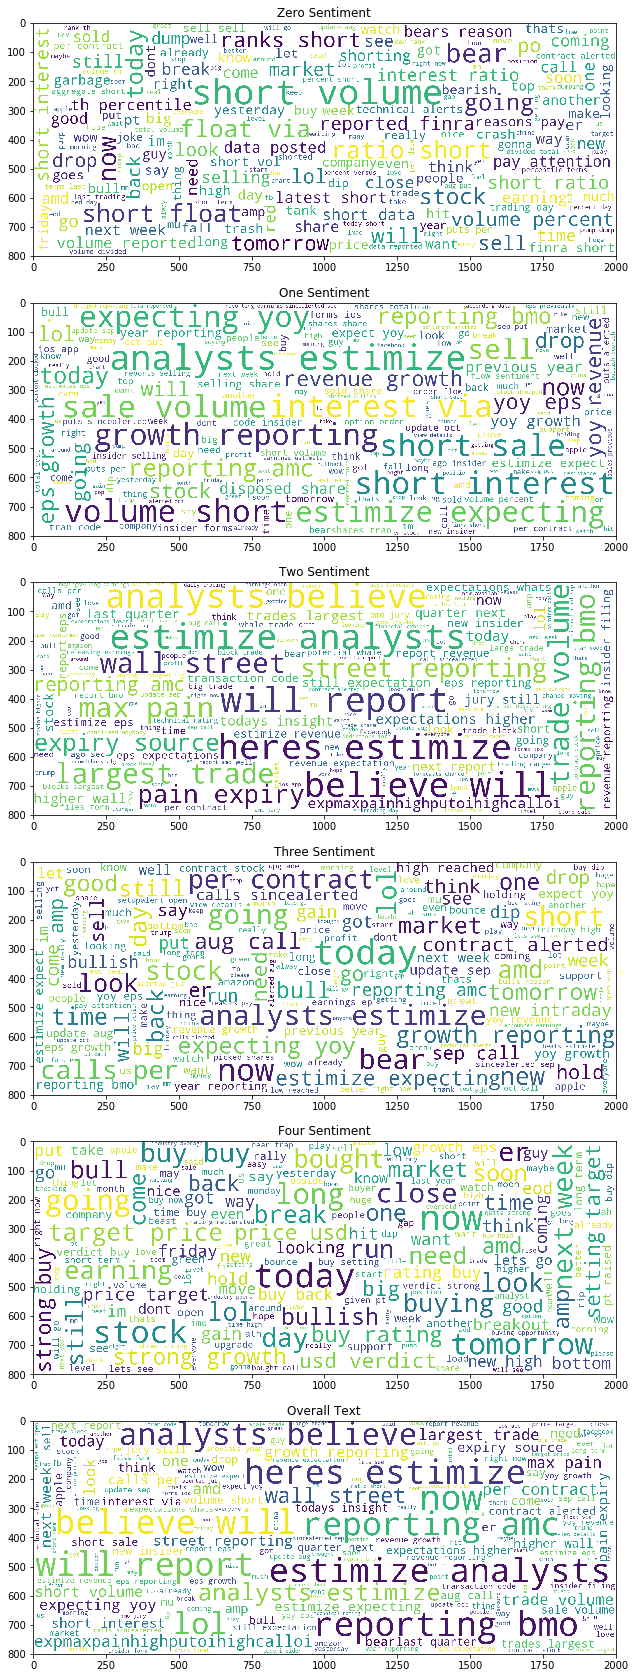

In [44]:
from wordcloud import WordCloud
from matplotlib import rcParams
fig = plt.figure(figsize = (100,30))
for i in range(6):
    img = WordCloud(width=2000, height=800, random_state=26, max_font_size=120, background_color= 'white').generate(text[i])
    fig.add_subplot(6, 1, i+1)
    #plt.axis('off')
    plt.title(labels[i])
    plt.imshow(img)
plt.show()

**Now that we have cleaned the text, we remove stopwords and lemmatize the text.**

### Tokenize - Train

In [45]:
token_text = []

for i in tq(sent_data['clean_text']):
    sleep(0.01)
    token_text.append(word_tokenize(i))
    
sent_data['token_tweet'] = token_text

In [46]:
sent_data.tail()

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet,clean_text,token_tweet
1039126,2,$CLF https://twitter.com/hrdrckminer/status/10...,CLF,8,13,,[]
1039127,3,$AMD 🔥🔥🔥,AMD,9,4,,[]
1039128,0,$FB damn should of shorted 196 after hours to ...,FB,7,25,damn should of shorted after hours to late now,"[damn, should, of, shorted, after, hours, to, ..."
1039129,0,$AMD back to the 31&#39;s,AMD,9,28,back to the s,"[back, to, the, s]"
1039130,2,$AMZN Lagging other tech today.,AMZN,7,5,lagging other tech today,"[lagging, other, tech, today]"


### Tokenize - Test

In [108]:
token_text_test = []

for i in tq(sent_data_test['clean_text_test']):
    sleep(0.01)
    token_text_test.append(word_tokenize(i))
    
sent_data_test['token_tweet'] = token_text_test

print(sent_data_test.tail())


                                          stocktwit_tweet ticker  \
265017  $CVS recent bad PR made this an easy pick to l...    CVS   
265018  Here’s what 16 Estimize analysts believe $S wi...      S   
265019  $AMD Could be at 18 or high 17s.  If not, will...    AMD   
265020  $TSN files form 10-Q https://fintel.io/filings...    TSN   
265021  $AAPL looks like it is solidly supporting its ...   AAPL   

        month_of_tweet  day_of_tweet  \
265017               7            20   
265018              10            24   
265019               7            25   
265020               8             6   
265021               9            27   

                                          clean_text_test  \
265017   recent bad pr made this an easy pick to load ...   
265018  heres what  estimize analysts believe  will re...   
265019   could be at  or high s  if not will still get...   
265020                                      files form q    
265021   looks like it is solidly supporting

### Remove stop words - Train

In [47]:
nltk.download('stopwords')
nltk.download('punkt')
stopset = set(w.lower() for w in stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UrMili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\UrMili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
stop_words_removed = []

for tokenized_words in tq(sent_data['token_tweet']):
    sleep(0.01)
    
    stop_words_removed.append([word for word in tokenized_words if word not in stopset])
    
sent_data['sw_rem_data'] = stop_words_removed

In [49]:
sent_data['clean_text'][5]

' as usualred   every day'

In [50]:
sent_data['sw_rem_data'][5]

['usualred', 'every', 'day']

### Remove Stop Words - Test

In [109]:
nltk.download('stopwords')
nltk.download('punkt')
stopset = set(w.lower() for w in stopwords.words('english'))

stop_words_removed_test = []

for tokenized_words in tq(sent_data_test['token_tweet']):
    sleep(0.01)
    
    stop_words_removed_test.append([word for word in tokenized_words if word not in stopset])
    
sent_data_test['sw_rem_data'] = stop_words_removed_test

print(sent_data_test.tail(2))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UrMili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\UrMili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



                                          stocktwit_tweet ticker  \
265020  $TSN files form 10-Q https://fintel.io/filings...    TSN   
265021  $AAPL looks like it is solidly supporting its ...   AAPL   

        month_of_tweet  day_of_tweet  \
265020               8             6   
265021               9            27   

                                          clean_text_test  \
265020                                      files form q    
265021   looks like it is solidly supporting its gains...   

                                              token_tweet  \
265020                                   [files, form, q]   
265021  [looks, like, it, is, solidly, supporting, its...   

                                              sw_rem_data  
265020                                   [files, form, q]  
265021  [looks, like, solidly, supporting, gains, look...  


### Lemmatize the text - Train

In [51]:
lemmatizer = WordNetLemmatizer()

In [52]:
sent_data['lemma_data'] = sent_data["sw_rem_data"].apply(lambda x: [lemmatizer.lemmatize(y,pos = 'v') for y in x])

In [53]:
sent_data['stocktwit_tweet'][0]

'$AMD going up but hesitating however chart is very stable and going upward'

In [54]:
sent_data['lemma_data'][0]

['go', 'hesitate', 'however', 'chart', 'stable', 'go', 'upward']

### Lemmatize Text - Test

In [110]:
lemmatizer = WordNetLemmatizer()

sent_data_test['lemma_data'] = sent_data_test["sw_rem_data"].apply(lambda x: [lemmatizer.lemmatize(y,pos = 'v') for y in x])

print(sent_data_test)

                                          stocktwit_tweet ticker  \
0                        $CELG nothing to be exited about   CELG   
1       $AMD yall exhaust your buyer on first green ca...    AMD   
2                                   $AMD day traders day.    AMD   
3                         $CBS https://tenor.com/wLB8.gif    CBS   
4       $MU weak price action so far today. Don’t be a...     MU   
5       $AMZN continues to grow, specifically in key a...   AMZN   
6       $CLF If you are not loading up right now, you ...    CLF   
7       $MU crap shoot. Legit no one knows if it’s goi...     MU   
8       $AMD how does this chart look like a setup for...    AMD   
9             $AMD amd is like my sex life. Its so dry rn    AMD   
10      $AMD FINALLY AMD GOT ITS ANTI-GRAVITY TECHNOLO...    AMD   
11      $SYF seems like a lot of todo to halt with 30 ...    SYF   
12      $FB you know Mark has been dumping more shares...     FB   
13      $NKE Remember this Trumppalo Boycott? AA

[265022 rows x 8 columns]


### Adding Tweet Length - Train

In [55]:
sent_data['tweet_length'] = sent_data['clean_text'].apply(lambda x: len(x))

In [56]:
sent_data.tail()

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet,clean_text,token_tweet,sw_rem_data,lemma_data,tweet_length
1039126,2,$CLF https://twitter.com/hrdrckminer/status/10...,CLF,8,13,,[],[],[],1
1039127,3,$AMD 🔥🔥🔥,AMD,9,4,,[],[],[],1
1039128,0,$FB damn should of shorted 196 after hours to ...,FB,7,25,damn should of shorted after hours to late now,"[damn, should, of, shorted, after, hours, to, ...","[damn, shorted, hours, late]","[damn, short, hours, late]",48
1039129,0,$AMD back to the 31&#39;s,AMD,9,28,back to the s,"[back, to, the, s]",[back],[back],14
1039130,2,$AMZN Lagging other tech today.,AMZN,7,5,lagging other tech today,"[lagging, other, tech, today]","[lagging, tech, today]","[lag, tech, today]",25


### Adding Tweet Length - Test

In [112]:
sent_data_test['tweet_length'] = sent_data_test['clean_text_test'].apply(lambda x: len(x))

print(sent_data_test.tail())

                                          stocktwit_tweet ticker  \
265017  $CVS recent bad PR made this an easy pick to l...    CVS   
265018  Here’s what 16 Estimize analysts believe $S wi...      S   
265019  $AMD Could be at 18 or high 17s.  If not, will...    AMD   
265020  $TSN files form 10-Q https://fintel.io/filings...    TSN   
265021  $AAPL looks like it is solidly supporting its ...   AAPL   

        month_of_tweet  day_of_tweet  \
265017               7            20   
265018              10            24   
265019               7            25   
265020               8             6   
265021               9            27   

                                          clean_text_test  \
265017   recent bad pr made this an easy pick to load ...   
265018  heres what  estimize analysts believe  will re...   
265019   could be at  or high s  if not will still get...   
265020                                      files form q    
265021   looks like it is solidly supporting 

### Adding Number of Hashtags in the tweet - Train

In [113]:
def extract_num_hashtags(tweet):
    hashtags = [word for word in tweet.split() if word.startswith("#")]
    return len(hashtags)

In [58]:
sent_data['no_of_hashtags'] = sent_data['stocktwit_tweet'].apply(lambda x: extract_num_hashtags(x))

In [59]:
sent_data['no_of_hashtags'].value_counts()

0     999435
1      33885
2       3858
3       1274
4        439
6        102
5        100
7         17
8         16
9          4
23         1
Name: no_of_hashtags, dtype: int64

### Adding Number of Hashtags in the tweet - Test

In [114]:
sent_data_test['no_of_hashtags'] = sent_data_test['stocktwit_tweet'].apply(lambda x: extract_num_hashtags(x))

print(sent_data_test['no_of_hashtags'].value_counts())

0     255100
1       8463
2        984
3        303
4        108
5         27
6         26
8          5
7          5
12         1
Name: no_of_hashtags, dtype: int64


# Data Visualization

## For Train Factors

In [60]:
train_data.tail()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
27001,27002,05/10/18,RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,5,10
27002,27003,30/07/18,PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,30,7
27003,27004,16/10/18,JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,16,10
27004,27005,27/07/18,NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,27,7
27005,27006,14/10/18,WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2,14,10


In [61]:
sns.set(style='darkgrid')

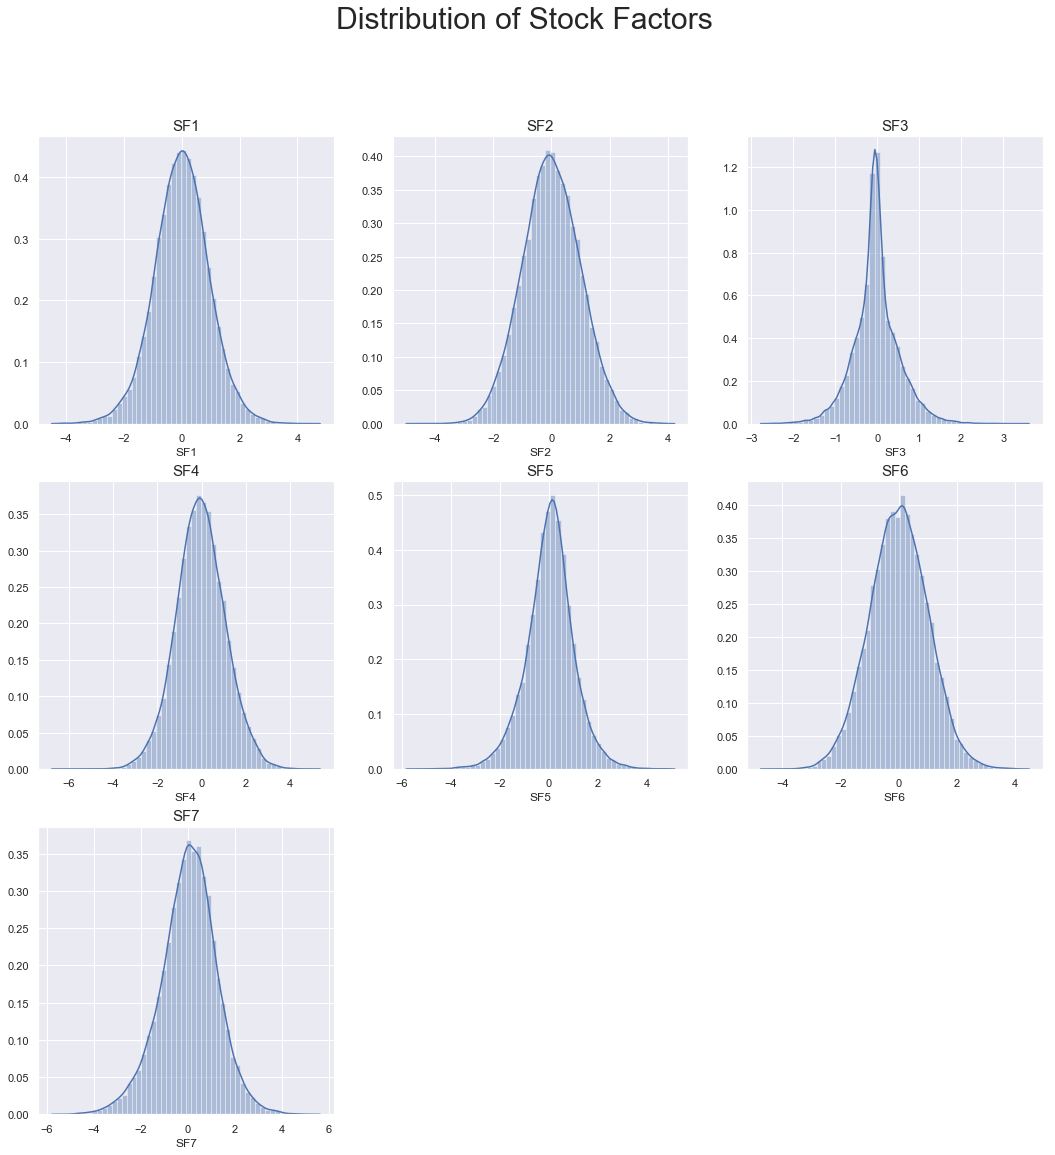

In [62]:
fig, ax = plt.subplots(figsize=(18,18))
fig.suptitle('Distribution of Stock Factors', fontsize = 30)

plt.subplot(331)
ax1 = sns.distplot(train_data['SF1'])
ax1.set_title('SF1', fontsize = 15)


plt.subplot(332)
ax2 = sns.distplot(train_data['SF2'])
ax2.set_title('SF2', fontsize = 15)


plt.subplot(333)
ax3 = sns.distplot(train_data['SF3'])
ax3.set_title('SF3', fontsize = 15)


plt.subplot(334)
ax4 = sns.distplot(train_data['SF4'])
ax4.set_title('SF4', fontsize = 15)


plt.subplot(335)
ax5 = sns.distplot(train_data['SF5'])
ax5.set_title('SF5', fontsize = 15)


plt.subplot(336)
ax6 = sns.distplot(train_data['SF6'])
ax6.set_title('SF6', fontsize = 15)

plt.subplot(337)
ax7 = sns.distplot(train_data['SF7'])
ax7.set_title('SF7', fontsize = 15)


plt.show()

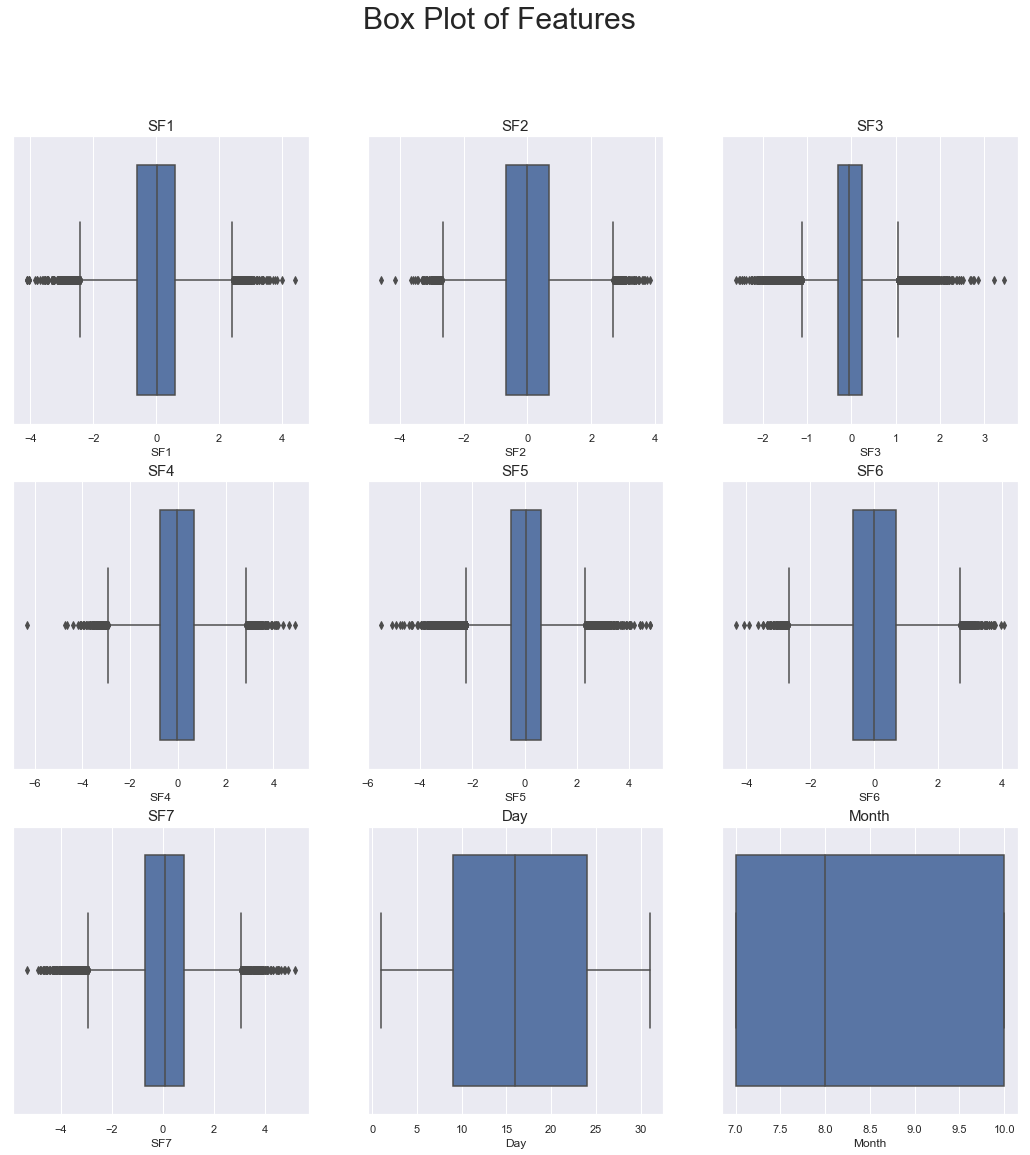

In [63]:
fig, ax = plt.subplots(figsize=(18,18))
fig.suptitle('Box Plot of Features', fontsize = 30)

plt.subplot(331)
ax1 = sns.boxplot(train_data['SF1'])
ax1.set_title('SF1', fontsize = 15)


plt.subplot(332)
ax2 = sns.boxplot(train_data['SF2'])
ax2.set_title('SF2', fontsize = 15)


plt.subplot(333)
ax3 = sns.boxplot(train_data['SF3'])
ax3.set_title('SF3', fontsize = 15)


plt.subplot(334)
ax4 = sns.boxplot(train_data['SF4'])
ax4.set_title('SF4', fontsize = 15)


plt.subplot(335)
ax5 = sns.boxplot(train_data['SF5'])
ax5.set_title('SF5', fontsize = 15)


plt.subplot(336)
ax6 = sns.boxplot(train_data['SF6'])
ax6.set_title('SF6', fontsize = 15)

plt.subplot(337)
ax7 = sns.boxplot(train_data['SF7'])
ax7.set_title('SF7', fontsize = 15)

plt.subplot(338)
ax8 = sns.boxplot(train_data['Day'])
ax8.set_title('Day', fontsize = 15)

plt.subplot(339)
ax9 = sns.boxplot(train_data['Month'])
ax9.set_title('Month', fontsize = 15)


plt.show()

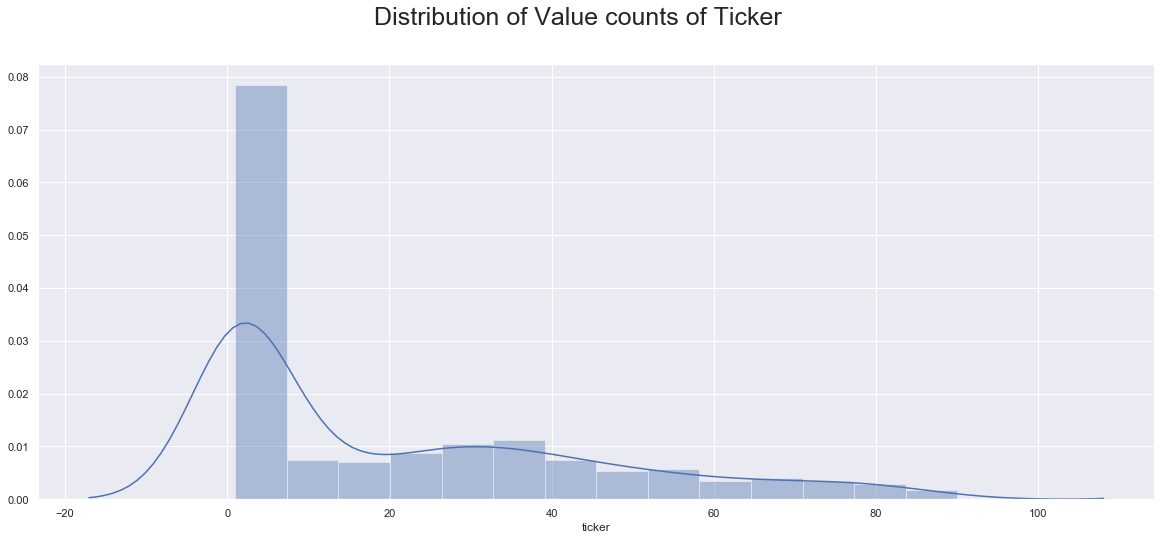

In [64]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Distribution of Value counts of Ticker', fontsize = 25)
sns.distplot(train_data['ticker'].value_counts())

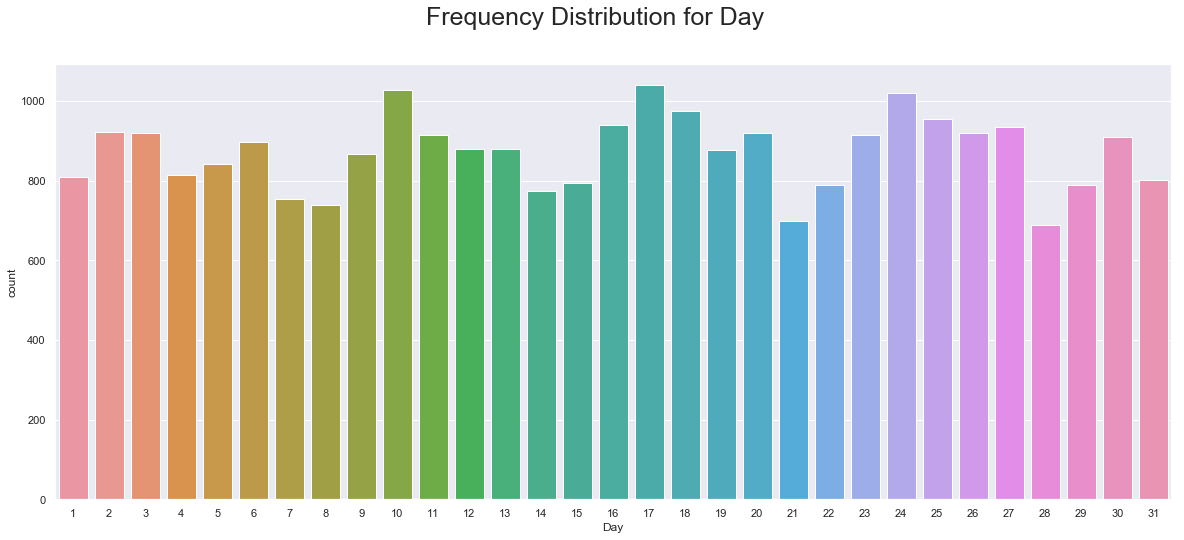

In [65]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Day', fontsize = 25)
sns.countplot(train_data['Day'])

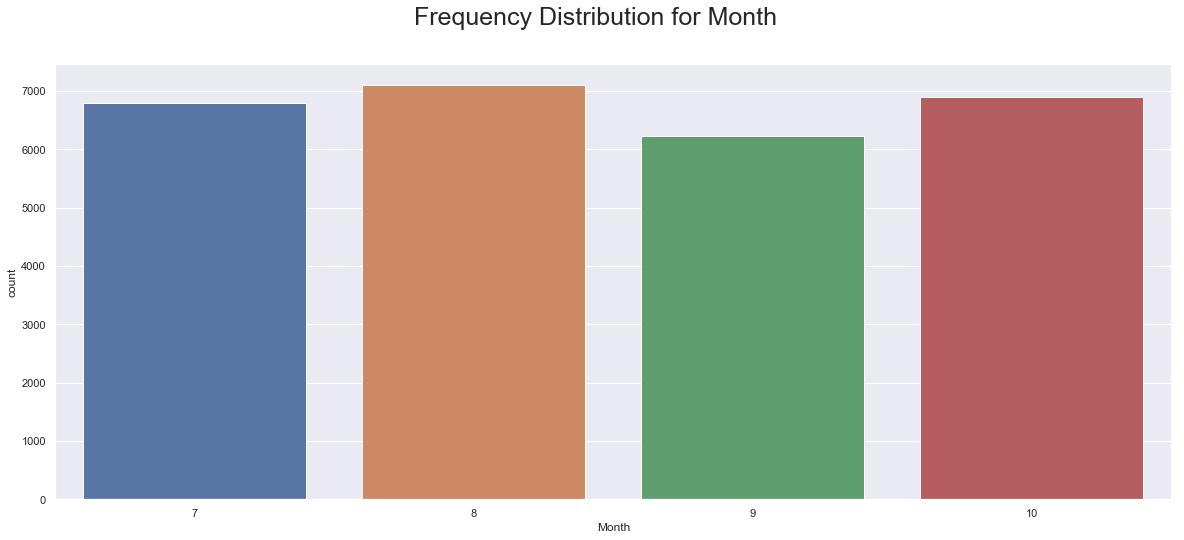

In [66]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Month', fontsize = 25)
sns.countplot(train_data['Month'])

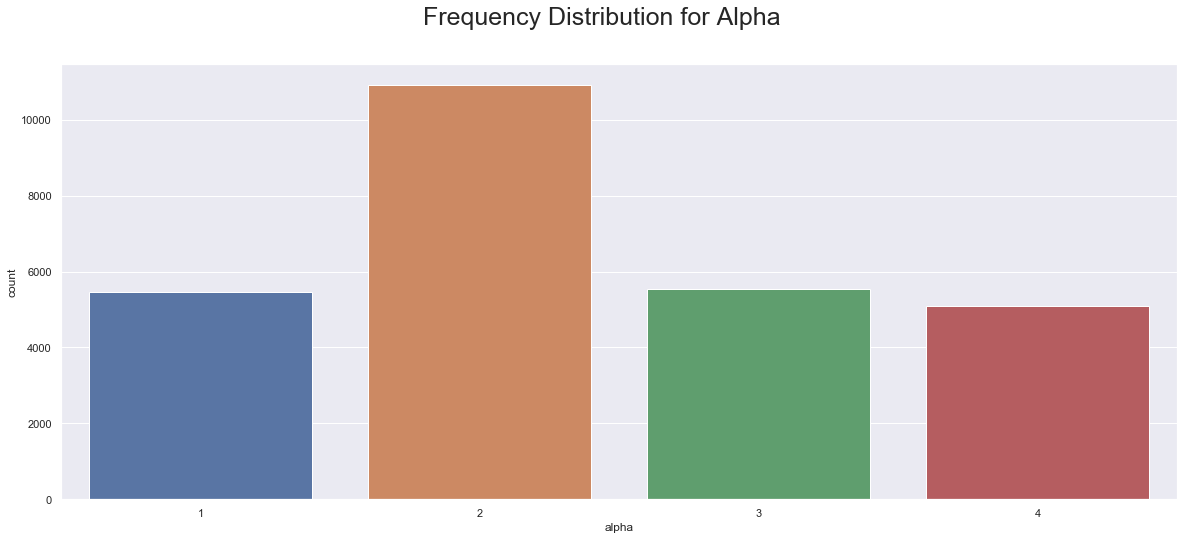

In [67]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Alpha', fontsize = 25)
sns.countplot(train_data['alpha'])

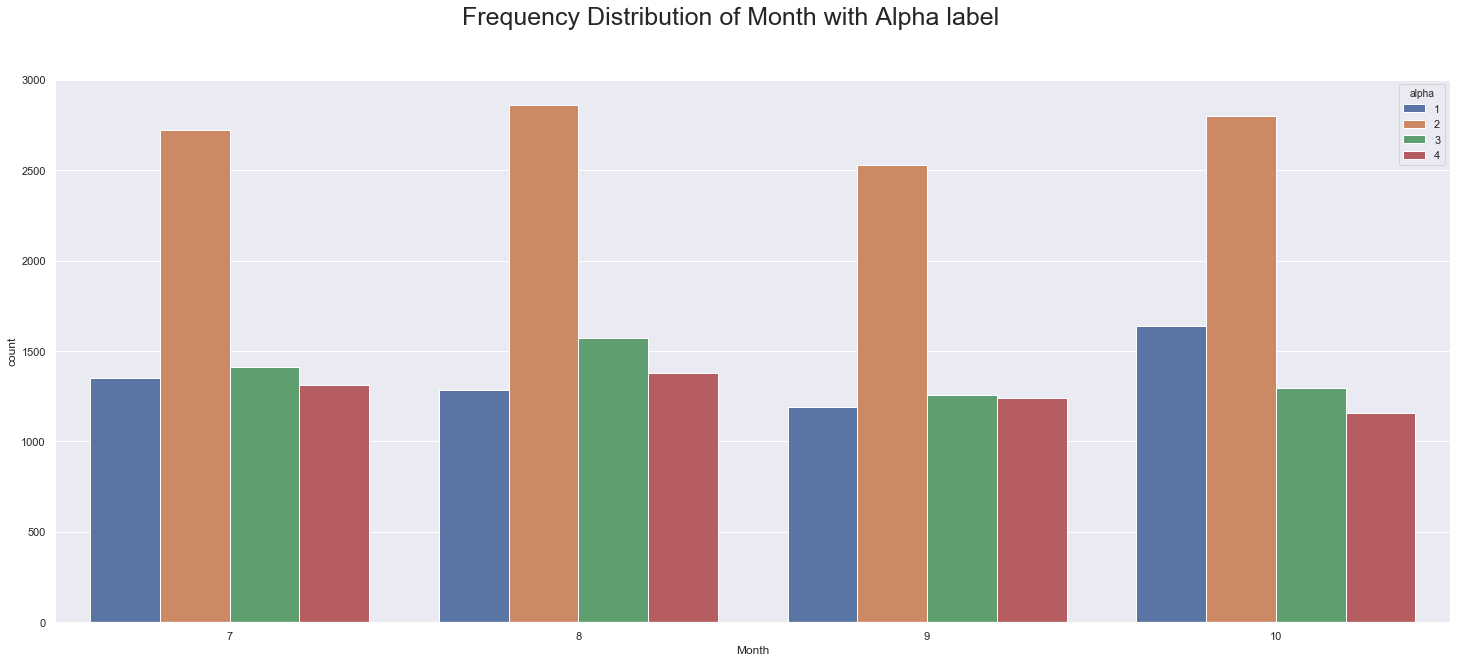

In [68]:
f,ax=plt.subplots(figsize = (25,10))
f.suptitle('Frequency Distribution of Month with Alpha label', fontsize = 25)
sns.countplot(train_data['Month'], hue = train_data['alpha'])

**Throughout months, alpha = 2 dominates.**

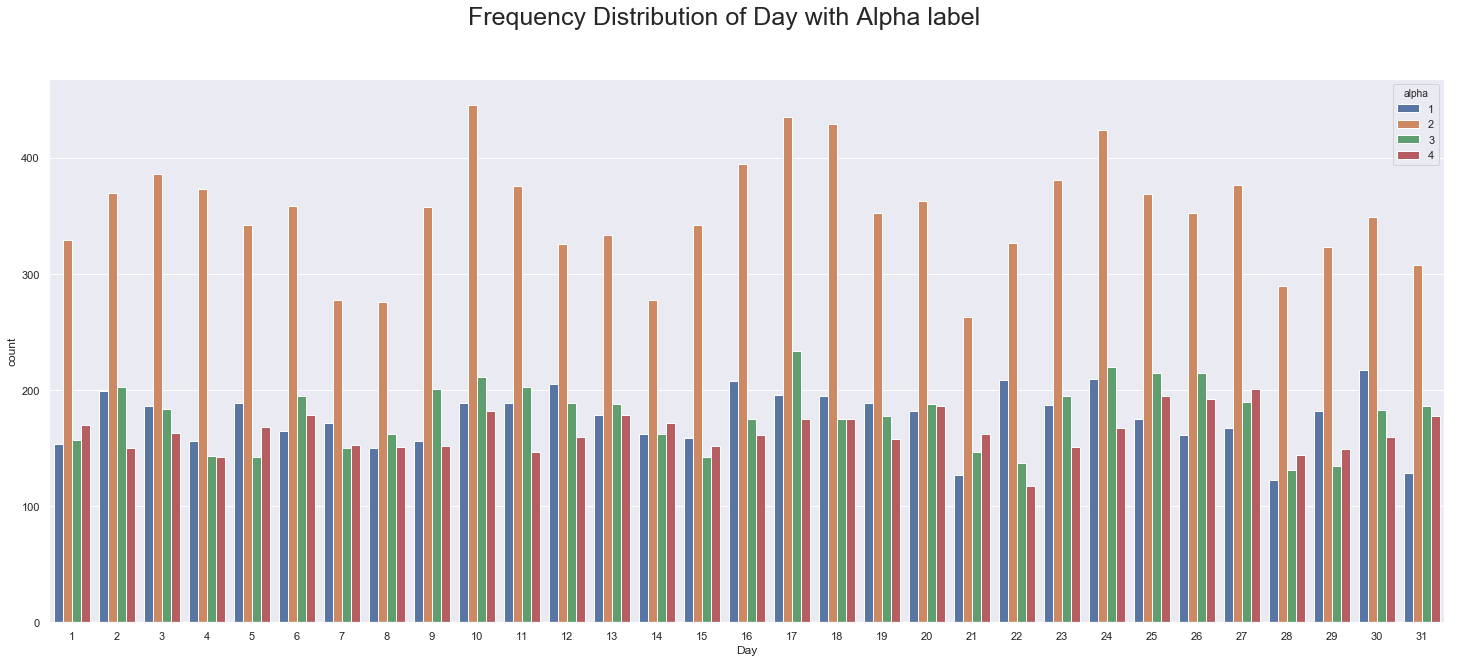

In [69]:
f,ax=plt.subplots(figsize = (25,10))
f.suptitle('Frequency Distribution of Day with Alpha label', fontsize = 25)
sns.countplot(train_data['Day'], hue = train_data['alpha'])

**Throughout Days too alpha = 2 dominates.**

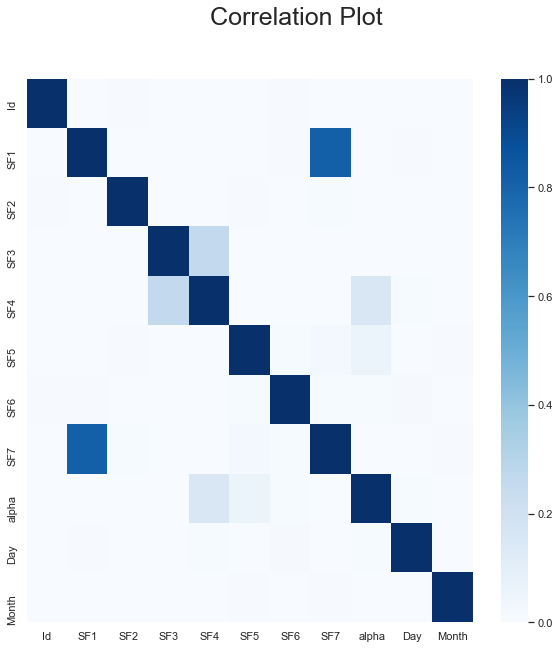

In [70]:
corr = train_data.corr()
f,ax=plt.subplots(figsize = (10,10))
f.suptitle('Correlation Plot', fontsize = 25)
sns.heatmap(corr, cmap = "Blues", vmin=0, vmax=1)

**There is a high correlation between SF1 and SF7.**

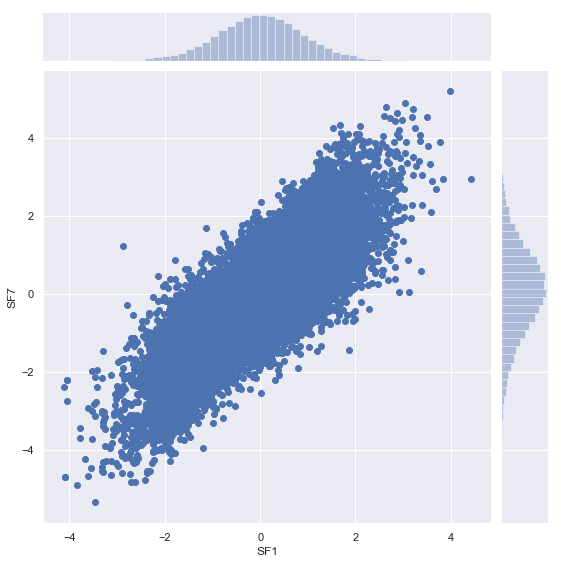

In [71]:
f.suptitle('Distribution of SF1 with SF7', fontsize = 25)
sns.jointplot(x = train_data['SF1'], y = train_data['SF7'], height = 8, ratio = 8)

## For Sentiment Train

In [72]:
sent_data.head()

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet,clean_text,token_tweet,sw_rem_data,lemma_data,tweet_length,no_of_hashtags
0,3,$AMD going up but hesitating however chart is ...,AMD,9,19,going up but hesitating however chart is very...,"[going, up, but, hesitating, however, chart, i...","[going, hesitating, however, chart, stable, go...","[go, hesitate, however, chart, stable, go, upw...",70,0
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,9,despite china trade war held very well,"[despite, china, trade, war, held, very, well]","[despite, china, trade, war, held, well]","[despite, china, trade, war, hold, well]",42,0
2,2,$AVGO WTF?,AVGO,7,12,wtf,[wtf],[wtf],[wtf],4,0
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,PH,7,19,new insider filing on muller klaus peter t...,"[new, insider, filing, on, muller, klaus, pete...","[new, insider, filing, muller, klaus, peter, t...","[new, insider, file, muller, klaus, peter, tra...",64,0
4,3,$FB if it bounces tommorrow do the right thing...,FB,8,23,if it bounces tommorrow do the right thing an...,"[if, it, bounces, tommorrow, do, the, right, t...","[bounces, tommorrow, right, thing, gtfo]","[bounce, tommorrow, right, thing, gtfo]",52,0


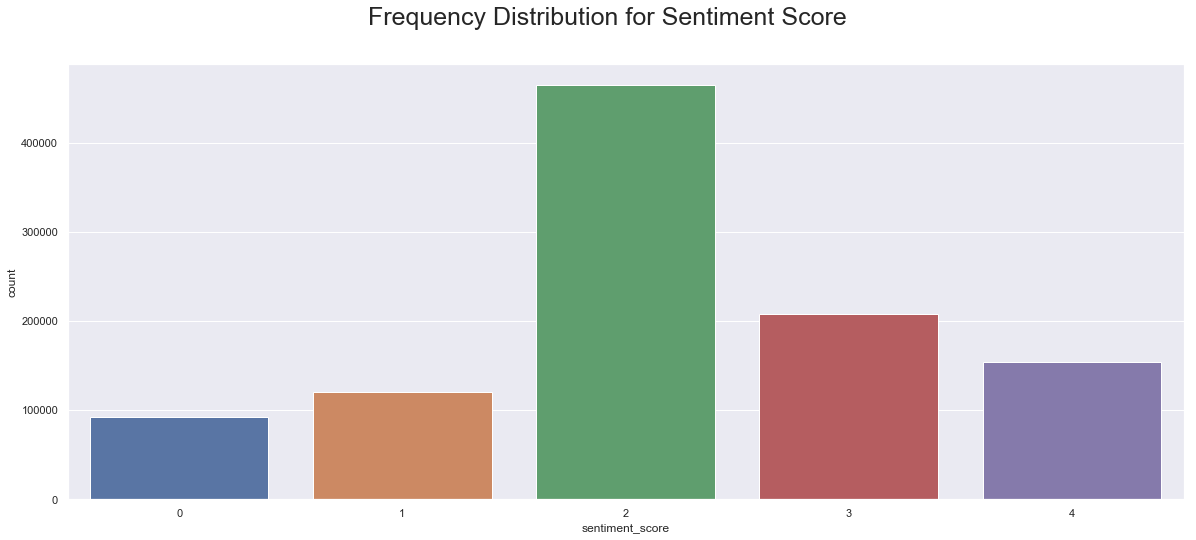

In [73]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Sentiment Score', fontsize = 25)
sns.countplot(sent_data['sentiment_score'])

<function matplotlib.pyplot.show(*args, **kw)>

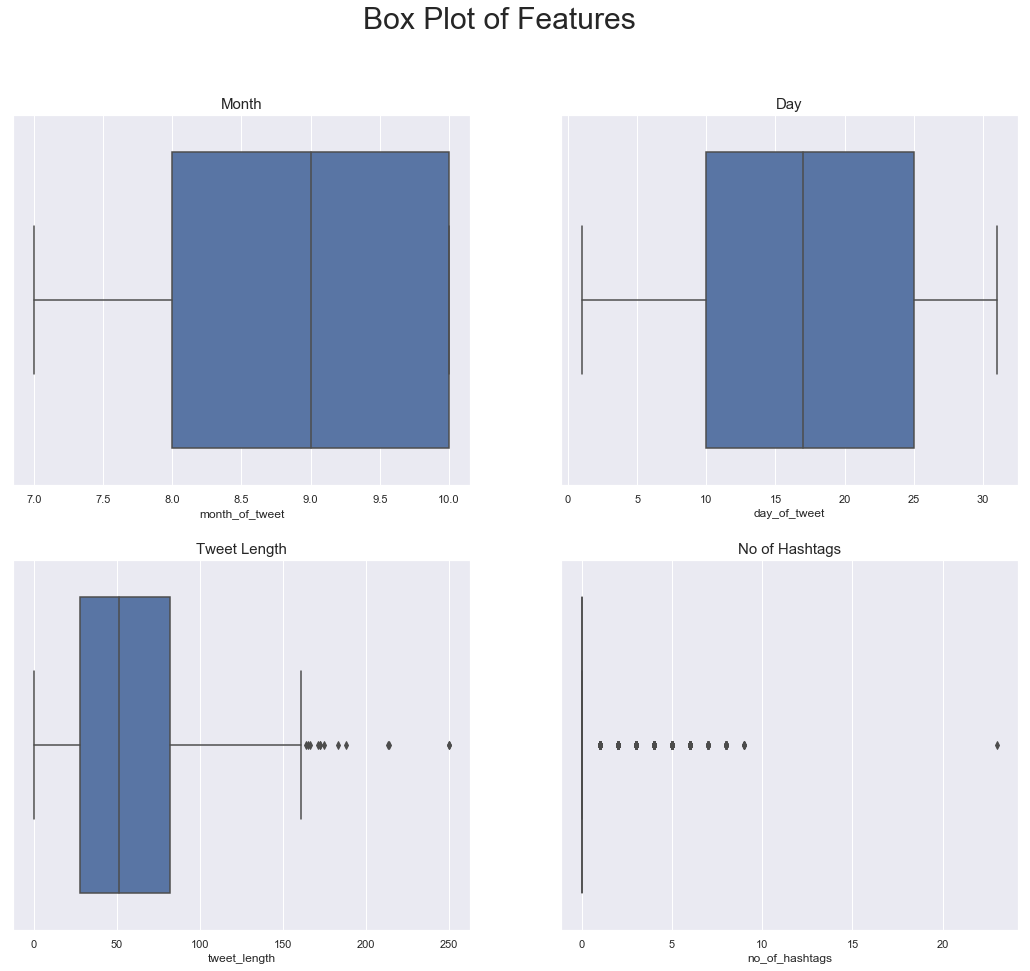

In [89]:
fig, ax = plt.subplots(figsize=(18,15))
fig.suptitle('Box Plot of Features', fontsize = 30)

plt.subplot(221)
ax1 = sns.boxplot(sent_data['month_of_tweet'])
ax1.set_title('Month', fontsize = 15)


plt.subplot(222)
ax2 = sns.boxplot(sent_data['day_of_tweet'])
ax2.set_title('Day', fontsize = 15)


plt.subplot(223)
ax3 = sns.boxplot(sent_data['tweet_length'])
ax3.set_title('Tweet Length', fontsize = 15)


plt.subplot(224)
ax4 = sns.boxplot(sent_data['no_of_hashtags'])
ax4.set_title('No of Hashtags', fontsize = 15)


plt.show

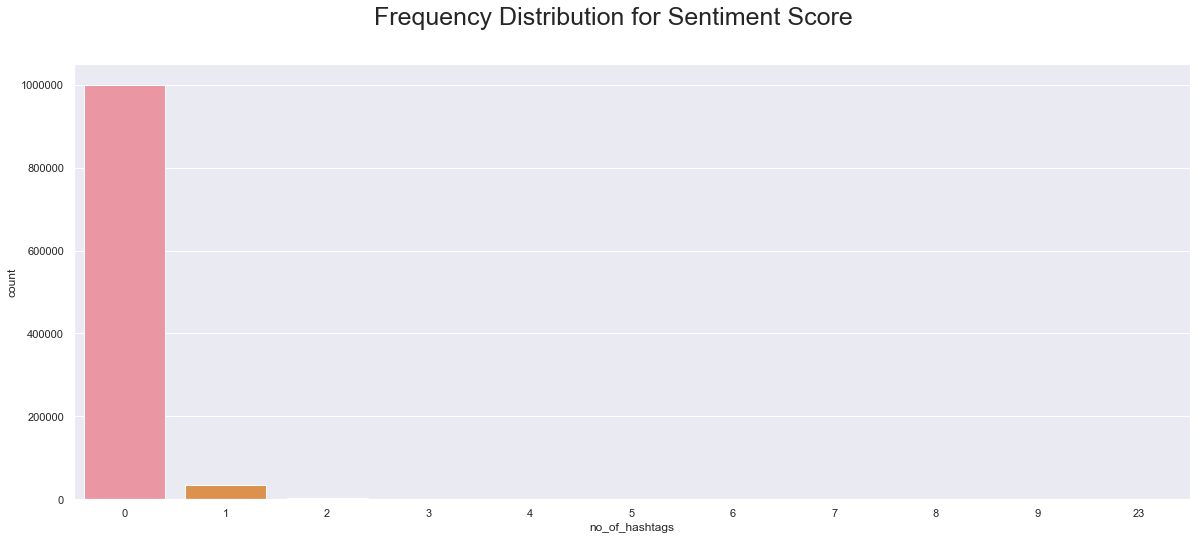

In [75]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Sentiment Score', fontsize = 25)
sns.countplot(sent_data['no_of_hashtags'])

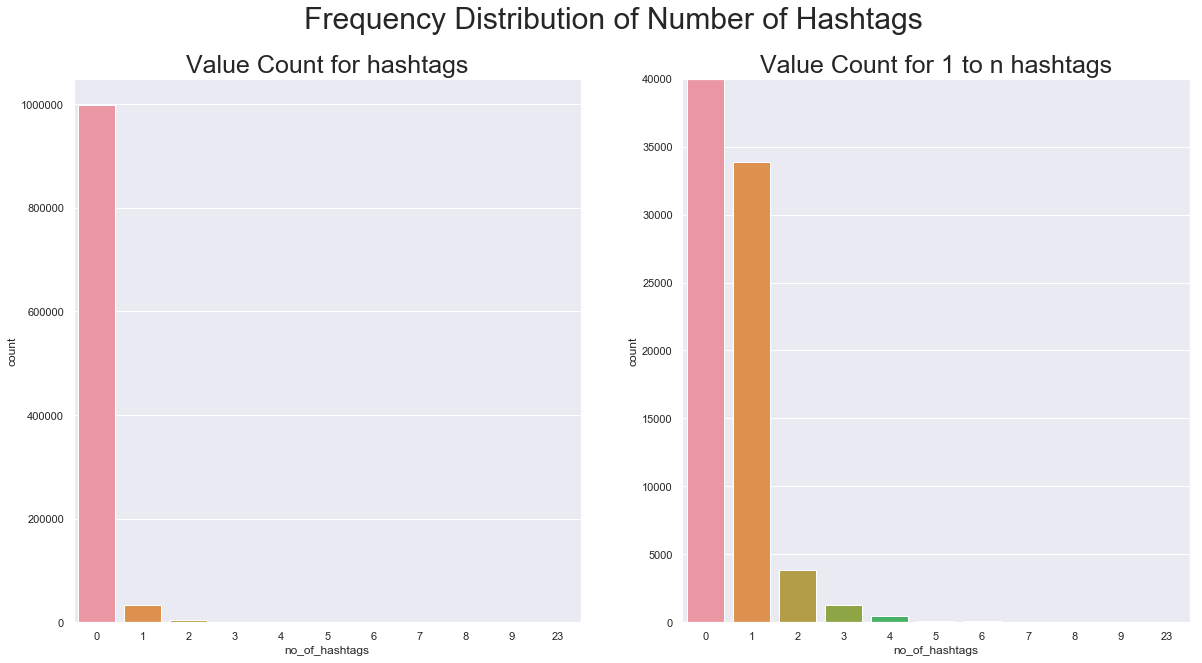

In [76]:
sns.set(style="darkgrid")
f,ax=plt.subplots(figsize = (20,10))
f.suptitle('Frequency Distribution of Number of Hashtags', fontsize = 30)

plt.subplot(121)
ax1 = sns.countplot(sent_data['no_of_hashtags'])
ax1.set_title('Value Count for hashtags', fontsize = 25)

plt.subplot(122)
ax2 = sns.countplot(sent_data['no_of_hashtags'])
plt.ylim(0, 40000)
ax2.set_title('Value Count for 1 to n hashtags', fontsize = 25)

plt.show()

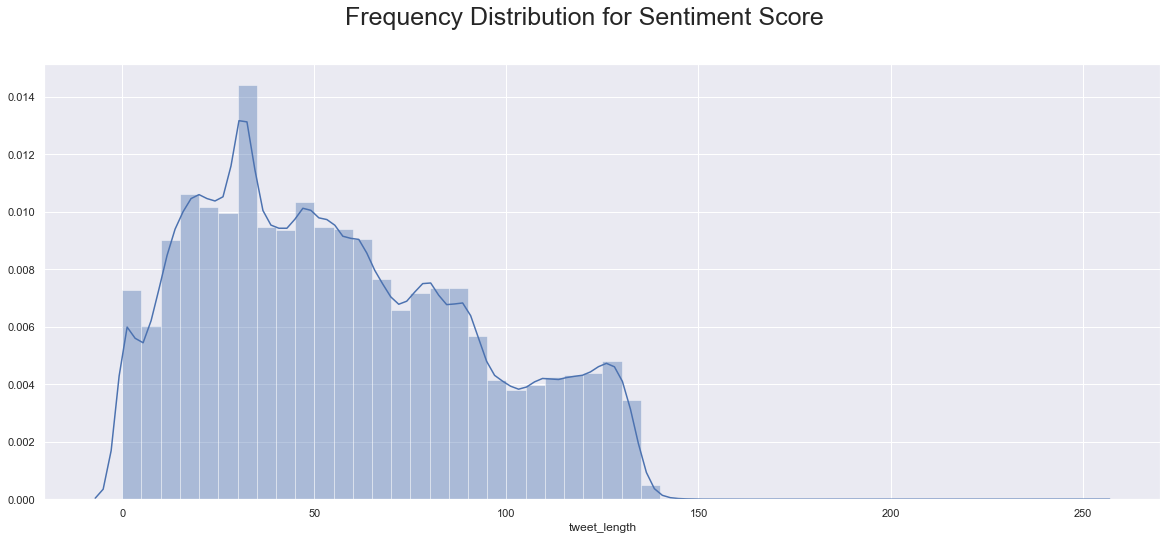

In [77]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Sentiment Score', fontsize = 25)
sns.distplot(sent_data['tweet_length'])

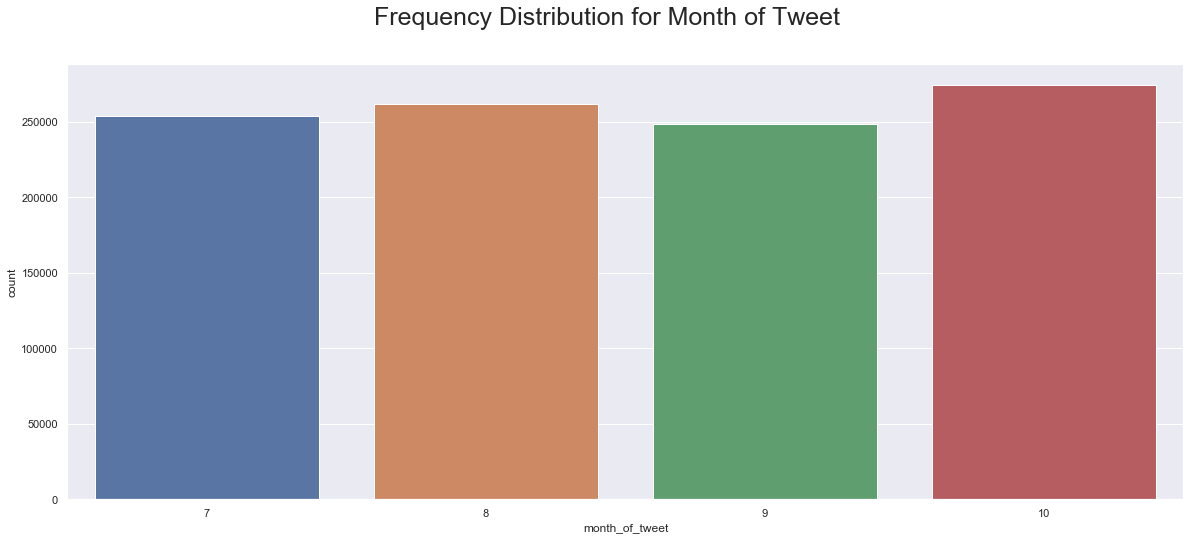

In [78]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Month of Tweet', fontsize = 25)
sns.countplot(sent_data['month_of_tweet'])

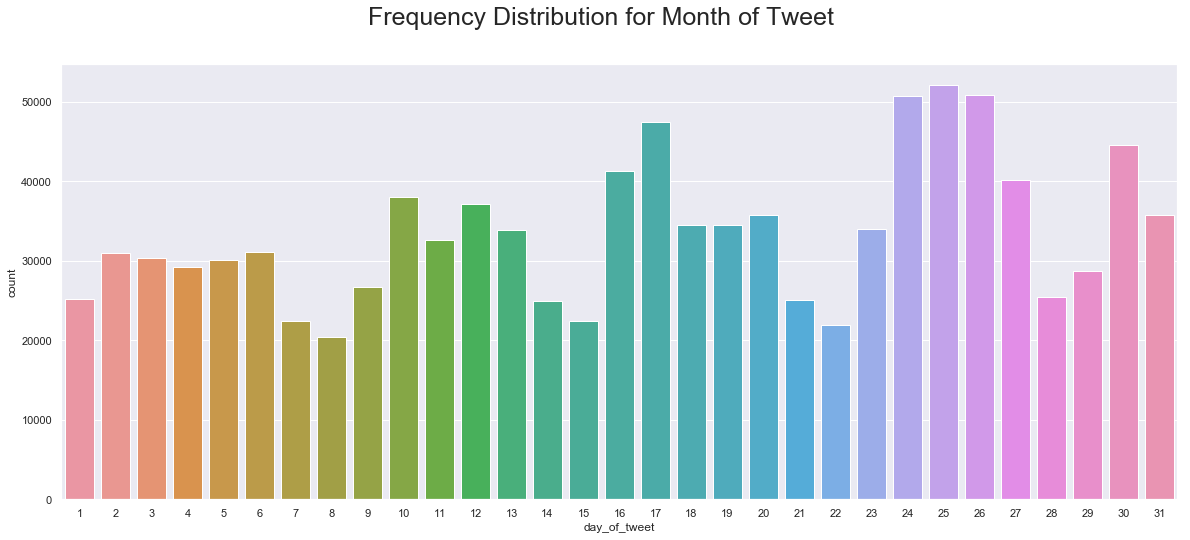

In [79]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Frequency Distribution for Month of Tweet', fontsize = 25)
sns.countplot(sent_data['day_of_tweet'])

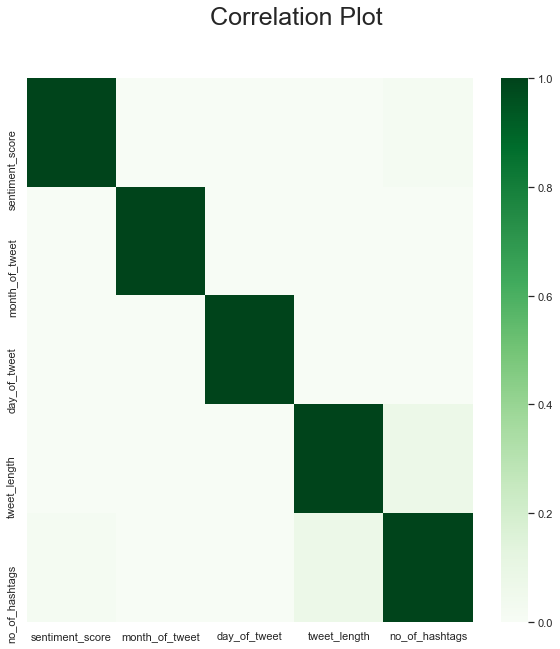

In [80]:
corr = sent_data.corr()
f,ax=plt.subplots(figsize = (10,10))
f.suptitle('Correlation Plot', fontsize = 25)
sns.heatmap(corr, cmap = "Greens", vmin=0, vmax=1)

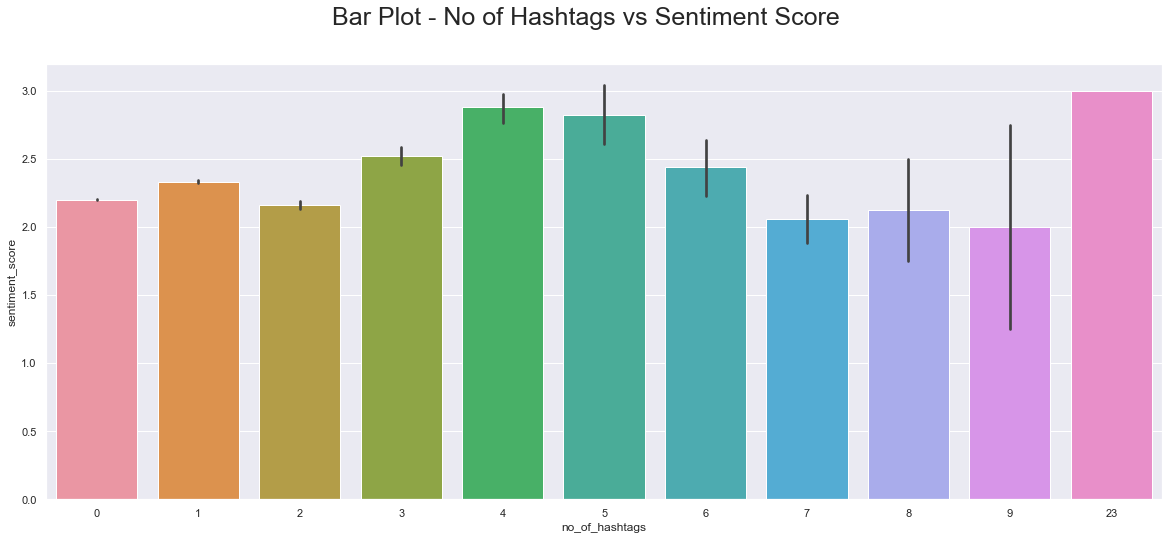

In [81]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Bar Plot - No of Hashtags vs Sentiment Score', fontsize = 25)
sns.barplot(x = sent_data['no_of_hashtags'], y = sent_data['sentiment_score'])

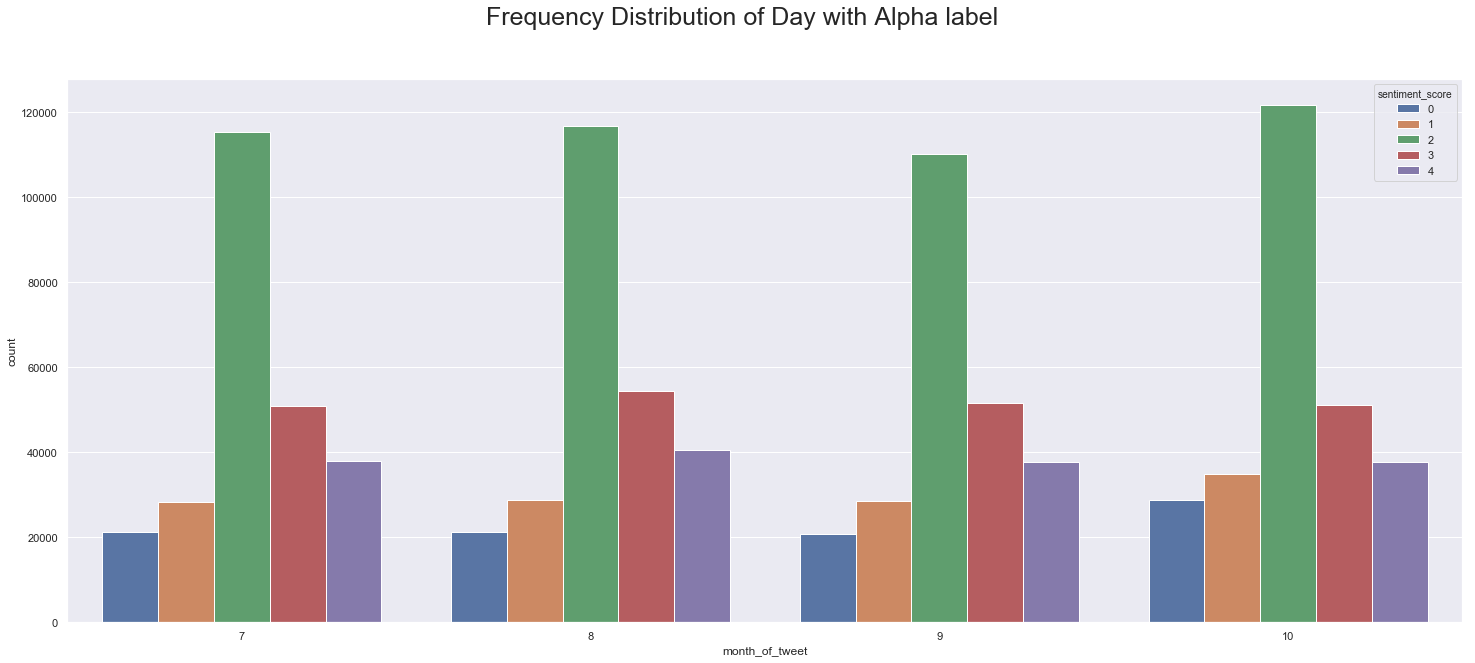

In [82]:
f,ax=plt.subplots(figsize = (25,10))
f.suptitle('Frequency Distribution of Day with Alpha label', fontsize = 25)
sns.countplot(sent_data['month_of_tweet'], hue = sent_data['sentiment_score'])

# Exporting the preprocessed data

## Train

In [83]:
sent_data.head(2)

,sentiment_score,stocktwit_tweet,ticker,month_of_tweet,day_of_tweet,clean_text,token_tweet,sw_rem_data,lemma_data,tweet_length,no_of_hashtags
0,3,$AMD going up but hesitating however chart is ...,AMD,9,19,going up but hesitating however chart is very...,"[going, up, but, hesitating, however, chart, i...","[going, hesitating, however, chart, stable, go...","[go, hesitate, however, chart, stable, go, upw...",70,0
1,3,@inforlong @MariaGascon Despite\nChina trade w...,CAT,10,9,despite china trade war held very well,"[despite, china, trade, war, held, very, well]","[despite, china, trade, war, held, well]","[despite, china, trade, war, hold, well]",42,0


In [84]:
final_sent_data = sent_data.drop(columns = ['stocktwit_tweet', 'clean_text', 'token_tweet', 'sw_rem_data'])

In [85]:
final_sent_data.to_csv('final_sent_data.csv')

In [86]:
train_data.head(2)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
0,1,21/08/18,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,8
1,2,11/10/18,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,10


In [87]:
final_train_data = train_data.drop(columns = 'date')

In [88]:
final_train_data.to_csv('final_train_data.csv')

## Test

In [116]:
final_sent_data_test = sent_data_test.drop(columns = ['stocktwit_tweet', 'clean_text_test', 'token_tweet', 'sw_rem_data'])

final_sent_data_test.to_csv('final_sent_data_test.csv')

In [117]:
final_test_data = test_data.drop(columns = 'date')

final_test_data.to_csv('final_test_data.csv')

In [118]:
final_test_data.head()

,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month
0,270007,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,21,07
1,270008,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,05,10
2,270009,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,01,10
3,270010,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,24,10
4,270011,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,27,07


In [119]:
final_test_data['ticker'].nunique()

1012

In [120]:
final_train_data['ticker'].nunique()

1300